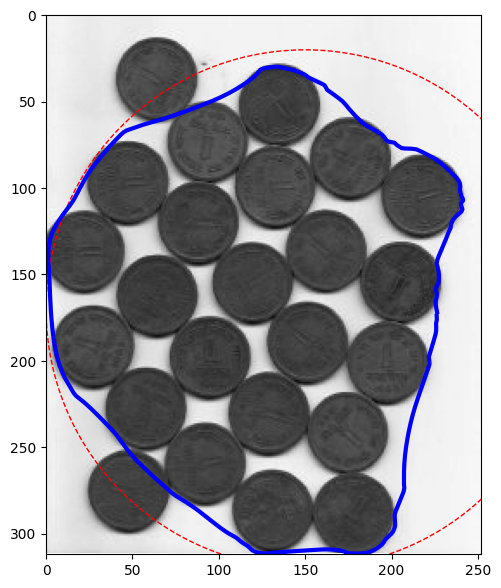

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Read and preprocess the image
img = cv2.imread('/content/coins.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Initialize the snake (contour)
s = np.linspace(0, 2*np.pi, 400)
r = 170 + 150*np.sin(s)
c = 150 + 150*np.cos(s)
init = np.array([r, c]).T

# START YOUR CODE

# Implement Gaussian filter with kernel size approximating 3x3 using sigma=1
gaussian_img = gaussian(img, sigma=1)

# Implement active contour using the specified parameters
snake = active_contour(gaussian_img, init, alpha=0.015, beta=10, gamma=0.001)

# END YOUR CODE

# Plotting the results
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=1)  # Initial contour in red dashed line
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)  # Final contour in blue solid line
ax.axis([0, img.shape[1], img.shape[0], 0])
plt.show()


Converged at iteration 17.


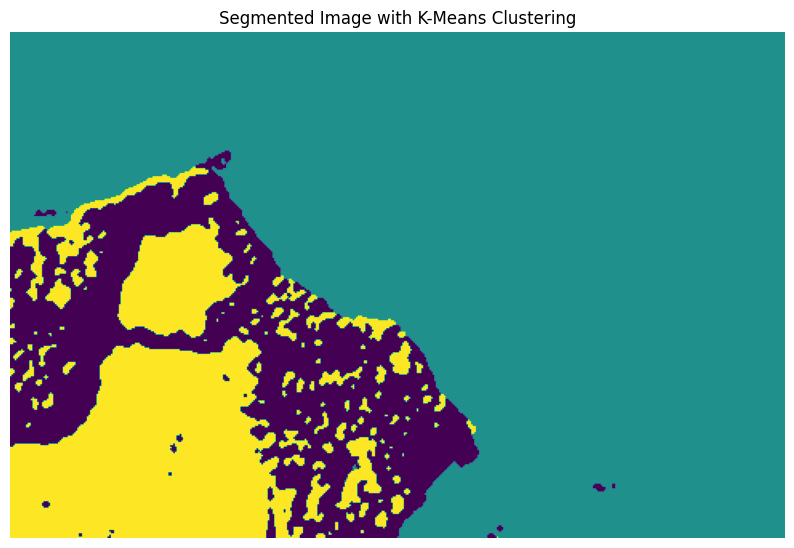

In [7]:
from sklearn.preprocessing import MinMaxScaler

def initialize_clusters(data, k):
    """
    Initialize clusters randomly from data points.
    """
    n_samples, _ = data.shape
    indices = np.random.choice(n_samples, size=k, replace=False)
    return data[indices]

def update_clusters(data, assignments, k):
    """
    Update cluster centroids based on the mean of assigned data points.
    """
    new_clusters = np.zeros((k, data.shape[1]))
    for cluster_idx in range(k):
        cluster_data = data[assignments == cluster_idx]
        if len(cluster_data) > 0:
            new_clusters[cluster_idx] = np.mean(cluster_data, axis=0)
        else:
            # Reinitialize centroid randomly if no points are assigned to it
            new_clusters[cluster_idx] = data[np.random.choice(len(data))]
    return new_clusters

def kmeans(data, k, max_iters=200):
    """
    Perform K-means clustering on the given data.
    """
    # Initialize clusters
    clusters = initialize_clusters(data, k)

    # Iterate until convergence or max iterations
    for iteration in range(max_iters):
        # Assign data points to the closest cluster centroid
        distances = np.linalg.norm(data[:, np.newaxis] - clusters, axis=2)
        assignments = np.argmin(distances, axis=1)

        # Update cluster centroids
        new_clusters = update_clusters(data, assignments, k)

        # Check for convergence
        if np.allclose(clusters, new_clusters):
            print(f"Converged at iteration {iteration}.")
            break

        clusters = new_clusters

    return assignments, clusters

# Read and preprocess the image
img = cv2.imread('/content/forColorSeg.png')  # Replace 'image.jpg' with your image file
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply Gaussian smoothing to reduce noise
smoothed_img = gaussian(img_rgb, sigma=1, channel_axis=-1)

# Convert image to Lab color space for better perceptual uniformity
img_lab = cv2.cvtColor((smoothed_img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)

# Get image dimensions
w, h, d = img_lab.shape

# Prepare data for clustering
# Flatten the Lab image
lab_flat = img_lab.reshape((-1, d))

# Create coordinate matrices and flatten them
x_coords, y_coords = np.meshgrid(np.arange(h), np.arange(w))
coords_flat = np.stack((x_coords.flatten(), y_coords.flatten()), axis=1)

# Combine Lab color features with spatial coordinates
# You can adjust the spatial weight to control the influence of spatial proximity
spatial_weight = 0.5  # Adjust this value between 0 and 1
color_weight = 1.0    # Weight for color features

# Scale color features to [0, 1]
color_scaler = MinMaxScaler()
lab_flat_scaled = color_scaler.fit_transform(lab_flat.astype(np.float64))

# Scale spatial features to [0, 1]
spatial_scaler = MinMaxScaler()
coords_flat_scaled = spatial_scaler.fit_transform(coords_flat.astype(np.float64))

# Apply weights to features
lab_flat_weighted = lab_flat_scaled * color_weight
coords_flat_weighted = coords_flat_scaled * spatial_weight

# Combine the weighted features
data = np.hstack((lab_flat_weighted, coords_flat_weighted))

# Set number of clusters and maximum iterations
n_clusters = 3
max_iters = 100

# Perform K-means clustering
assignments, clusters = kmeans(data, n_clusters, max_iters)

# Reshape assignments to the original image shape
clustered_image = assignments.reshape((w, h))

# Optionally apply median filtering to smooth the segmented image
from scipy.ndimage import median_filter
clustered_image_filtered = median_filter(clustered_image, size=3)

# Display the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image_filtered, cmap='viridis')
plt.axis('off')
plt.title('Segmented Image with K-Means Clustering')
plt.show()